In [13]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

import os
import pandas as pd

from PIL import Image

In [2]:
torch.cuda.is_available()

True

In [3]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [37]:
bar_transform = transforms.Compose([
    transforms.Resize((40, 30)),
    transforms.Grayscale(),
    transforms.ToTensor(),
])

data_dir = './data/features/numbers'

dataset = datasets.ImageFolder(root=data_dir, transform=bar_transform)

In [38]:
size = len(dataset)
size

677

In [39]:
train_size = int(0.8 * size)
test_size = size - train_size

In [40]:
train, test = random_split(
    dataset=dataset, lengths=[train_size, test_size]
)

In [41]:
image, label = train[0]
label

20

In [42]:
train_dl = DataLoader(train, batch_size=32, shuffle=True)
test_dl = DataLoader(test, batch_size=32, shuffle=False)

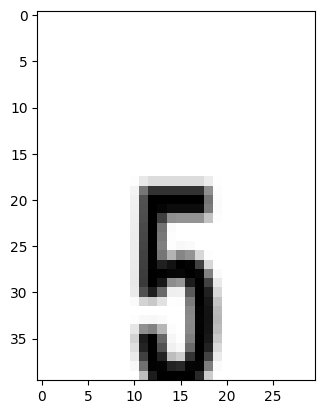

In [43]:
import matplotlib.pyplot as plt
plt.imshow(image.permute(1,2,0).squeeze(), cmap="gray")

In [44]:
image.shape

torch.Size([1, 40, 30])

In [48]:
class_names = train_dl.dataset.dataset.classes
class_names

['0',
 '1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '23',
 '24',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [49]:
class_to_idx = train_dl.dataset.dataset.class_to_idx
class_to_idx

{'0': 0,
 '1': 1,
 '10': 2,
 '11': 3,
 '12': 4,
 '13': 5,
 '14': 6,
 '15': 7,
 '16': 8,
 '17': 9,
 '18': 10,
 '19': 11,
 '2': 12,
 '20': 13,
 '21': 14,
 '22': 15,
 '23': 16,
 '24': 17,
 '3': 18,
 '4': 19,
 '5': 20,
 '6': 21,
 '7': 22,
 '8': 23,
 '9': 24}

In [52]:
custom_class_to_idx = {name: int(name) for name in class_names}
class_to_idx = {v: k for k, v in custom_class_to_idx.items()}
print("Custom class to index mapping:", custom_class_to_idx)
print("Custom index to class mapping:", class_to_idx)

Custom class to index mapping: {'0': 0, '1': 1, '10': 10, '11': 11, '12': 12, '13': 13, '14': 14, '15': 15, '16': 16, '17': 17, '18': 18, '19': 19, '2': 2, '20': 20, '21': 21, '22': 22, '23': 23, '24': 24, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}
Custom index to class mapping: {0: '0', 1: '1', 10: '10', 11: '11', 12: '12', 13: '13', 14: '14', 15: '15', 16: '16', 17: '17', 18: '18', 19: '19', 2: '2', 20: '20', 21: '21', 22: '22', 23: '23', 24: '24', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9'}


In [53]:
from torch import nn
latten_model = nn.Flatten()

In [54]:
train_features_batch, train_labels_batch = next(iter(train_dl))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 40, 30]), torch.Size([32]))

In [57]:
class NumberCNN(nn.Module):
  def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d( # convolutional layer
            in_channels=input_shape, # this should make sense
            out_channels=hidden_units,  # this should make sense
            kernel_size=3,
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels=hidden_units,
            out_channels=hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
          ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential( # this classifier layer takes the features
                                     # of our last layers, and classifies them
        nn.Flatten(), # note: if you see Flatten(), it generally means this is a classifier layer
        nn.Linear(in_features=hidden_units, # this needs to be determined (see the forward method)
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    print(f"output shape after cnv block 1: {x.shape}")
    x = self.conv_block_2(x)
    print(f"output shape after cnv block 2: {x.shape}")
    x = self.classifier(x)
    print(f"output shape after classifier: {x.shape}")
    return x
# A common practice in CNNs is to replicate the architecture of an existing,
# working model